In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

df = pd.read_csv('C3_anonymized.csv')
df.head(2)

,article_id,comment_author,comment_counter,comment_text,njudgements_constructiveness_expt,njudgements_toxicity_expt,agree_constructiveness_expt,agree_toxicity_expt,constructive,crowd_toxicity_level,...,constructive_characteristics,non_constructive_characteristics,toxicity_characteristics,crowd_comments_constructiveness_expt,crowd_comments_toxicity_expt,other_con_chars,other_noncon_chars,other_toxic_chars,constructive_binary,pp_comment_text
0,26023945,0,source1_26023945_62,And this Conservative strategy has produced th...,3.0,3.0,0.17,0.50,1.0,4.0,...,specific_points:3\ndialogue:2,no_non_con:3\nprovocative:1,abusive:3\npersonal_attack:1\nteasing:1\nembar...,\n\n,\n\n,\n\n,\n\n,\n\n,1.0,And this Conservative strategy has produced th...
1,24565777,1,source1_24565777_106,I commend Harper for holding the debates outsi...,3.0,3.0,0.33,0.17,1.0,3.0,...,specific_points:3\ndialogue:2,no_non_con:2\nno_respect:1,abusive:1\npersonal_attack:1\nteasing:1\nembar...,\n\n,\n\n,\n\n,\n\n,\n\n,1.0,I commend Harper for holding the debates outsi...


In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

df['processed_text'] = df['comment_text'].apply(preprocess_text)


In [3]:
analyzer = SentimentIntensityAnalyzer()

def analise2(texto):
    score = analyzer.polarity_scores(texto)
    compound = score['compound']
    return compound
    
df['sentiment_compound'] = df['comment_text'].apply(analise2)

In [4]:
def codifica_sentimento(x):
    if x >= 0.5:
        return 'positive'
    elif x <= -0.5:
        return 'negative'
    else:
        return 'neutral'
        
df['sentiment'] = df['sentiment_compound'].apply(codifica_sentimento)

In [5]:
df['sentiment'].value_counts()

sentiment
neutral     5267
positive    3645
negative    3088
Name: count, dtype: int64

In [6]:
tfidf = TfidfVectorizer(max_features=50) 
cat_tfidf = tfidf.fit_transform(df['comment_text'].fillna('')).toarray()

cat_df = pd.DataFrame(cat_tfidf, columns=[f'cat_{i}' for i in range(cat_tfidf.shape[1])])
df = pd.concat([df.reset_index(drop=True), cat_df], axis=1)

In [7]:
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
df = df.replace('', np.nan)
X = df.drop(['agree_constructiveness_expt', 'njudgements_constructiveness_expt', 'constructive', 'other_toxic_chars', 'other_noncon_chars', 'pp_comment_text', 'other_con_chars', 'crowd_comments_toxicity_expt', 'processed_text', 'constructive_binary', 'comment_counter', 'article_id', 'pp_comment_text', 'comment_text', 'has_content', 'crowd_discard', 'constructive_characteristics', 'non_constructive_characteristics', 'toxicity_characteristics', 'crowd_comments_constructiveness_expt', 'sentiment'], axis=1)
y = df['constructive_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)

# Optional: Detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9058333333333334
Precision: 0.9008202833706189
Recall: 0.9285165257494236
F1 Score: 0.9144587433762301

Confusion Matrix:
 [[ 966  133]
 [  93 1208]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      1099
         1.0       0.90      0.93      0.91      1301

    accuracy                           0.91      2400
   macro avg       0.91      0.90      0.90      2400
weighted avg       0.91      0.91      0.91      2400



In [8]:
df[['constructive_binary', 'sentiment_compound']].head(30)

,constructive_binary,sentiment_compound
0,1.0,-0.3400
1,1.0,-0.6901
2,1.0,0.8151
3,1.0,-0.8875
4,1.0,-0.9713
5,1.0,0.4926
6,1.0,-0.7786
7,1.0,0.6908
8,1.0,-0.8668
9,1.0,0.6597


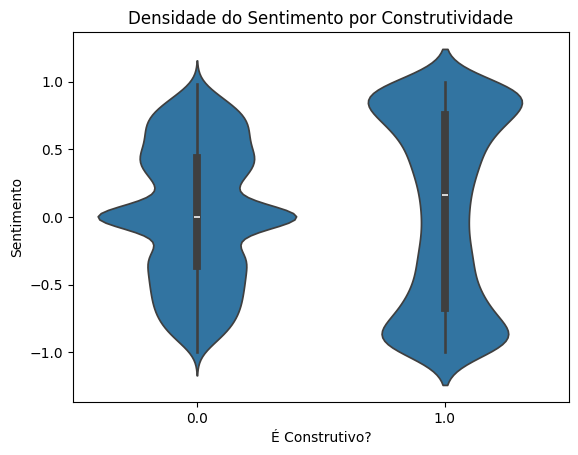

In [79]:
sns.violinplot(data=df, x='constructive_binary', y='sentiment_compound')
plt.title('Densidade do Sentimento por Construtividade')
plt.xlabel('É Construtivo?')
plt.ylabel('Sentimento')
plt.show()

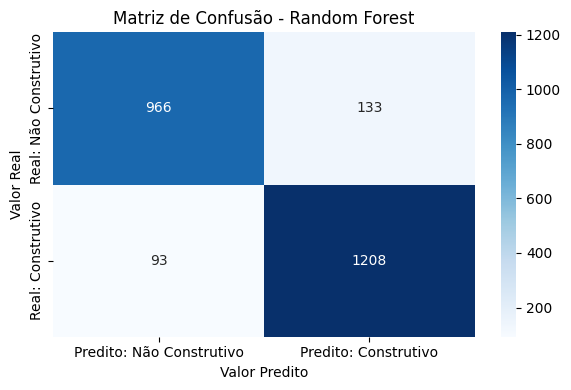

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Cria o heatmap da matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predito: Não Construtivo', 'Predito: Construtivo'],
            yticklabels=['Real: Não Construtivo', 'Real: Construtivo'])
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()